# Libraries

In [ ]:
import re
import pickle
import pprint
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    mutual_info_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve
)
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")


# Load dataset

In [2]:
# Load dataset
df = pd.read_csv('data/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Exploratory Data Analysis and Data Wrangling

In [3]:
# Explore data structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
# Convert CamelCase column names to snake_case
def camel_to_snake(col):
    return re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', col).lower()

df.columns = [camel_to_snake(col) for col in df.columns]
df.columns

Index(['administrative', 'administrative_duration', 'informational',
       'informational_duration', 'product_related', 'product_related_duration',
       'bounce_rates', 'exit_rates', 'page_values', 'special_day', 'month',
       'operating_systems', 'browser', 'region', 'traffic_type',
       'visitor_type', 'weekend', 'revenue'],
      dtype='object')

In [5]:
# Ensure booleans and target are numeric
df['weekend'] = df['weekend'].astype(int)
df['revenue'] = df['revenue'].astype(int)

# Define numerical, categorical and boolean column groups
num_cols = [
    'administrative', 
    'administrative_duration', 
    'informational',
    'informational_duration', 
    'product_related', 
    'product_related_duration',
    'bounce_rates', 
    'exit_rates', 
    'page_values', 
    'special_day'
]

cat_cols = [
    'month', 
    'operating_systems', 
    'browser', 
    'region', 
    'traffic_type', 
    'visitor_type',
    'weekend'  
]

bool_cols = ['weekend', 'revenue'] # for correlation purposes


In [6]:
# Normalize visitor_type formatting
df['visitor_type'] = df['visitor_type'].str.lower()

# Convert integer-like categoricals to strings
for col in ['operating_systems', 'browser', 'region', 'traffic_type']:
    df[col] = df[col].astype(str)

df.dtypes


administrative                int64
administrative_duration     float64
informational                 int64
informational_duration      float64
product_related               int64
product_related_duration    float64
bounce_rates                float64
exit_rates                  float64
page_values                 float64
special_day                 float64
month                        object
operating_systems            object
browser                      object
region                       object
traffic_type                 object
visitor_type                 object
weekend                       int64
revenue                       int64
dtype: object

In [7]:
# Categorical value counts
for col in cat_cols:
    display(df[col].value_counts())


month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

operating_systems
2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: count, dtype: int64

browser
2     7961
1     2462
4      736
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: count, dtype: int64

region
1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: count, dtype: int64

traffic_type
2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: count, dtype: int64

visitor_type
returning_visitor    10551
new_visitor           1694
other                   85
Name: count, dtype: int64

weekend
0    9462
1    2868
Name: count, dtype: int64

In [8]:
# A minimum count threshold is applied to rare categories to avoid statistically unreliable estimates caused by categories with too few observations.
min_count = 50

for col in cat_cols:
    if col == 'month':
        display(df[col].value_counts())
        continue

    counts = df[col].value_counts()
    rare_cats = counts[counts < min_count].index
    df[col] = df[col].replace(rare_cats, "other")

    display(df[col].value_counts())


month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

operating_systems
2        6601
1        2585
3        2555
4         478
8          79
other      32
Name: count, dtype: int64

browser
2        7961
1        2462
4         736
5         467
6         174
10        163
8         135
3         105
other      66
13         61
Name: count, dtype: int64

region
1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: count, dtype: int64

traffic_type
2        3913
1        2451
3        2052
4        1069
13        738
10        450
6         444
8         343
5         260
11        247
20        198
other     165
Name: count, dtype: int64

visitor_type
returning_visitor    10551
new_visitor           1694
other                   85
Name: count, dtype: int64

weekend
0    9462
1    2868
Name: count, dtype: int64

In [9]:
# Numerical columns summary
df[num_cols].describe()


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


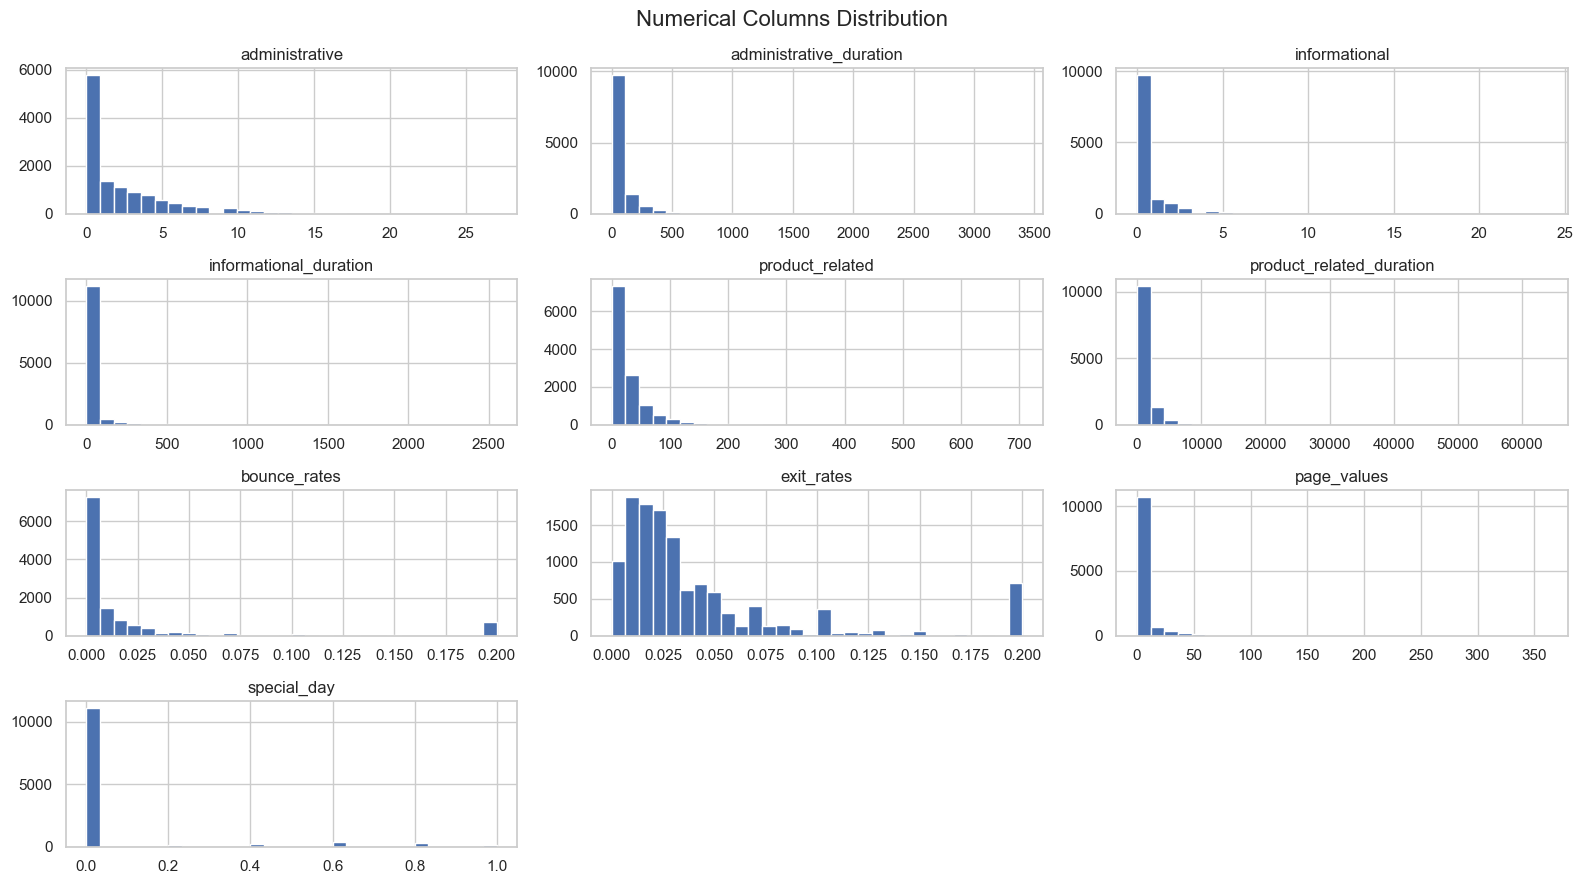

In [10]:
# Numerical column distributions
df[num_cols].hist(bins=30, figsize=(16, 9))
plt.suptitle('Numerical Columns Distribution', fontsize=16)
plt.tight_layout()
plt.show()


revenue
0    0.845255
1    0.154745
Name: proportion, dtype: float64

Conversion Rate:
0.15


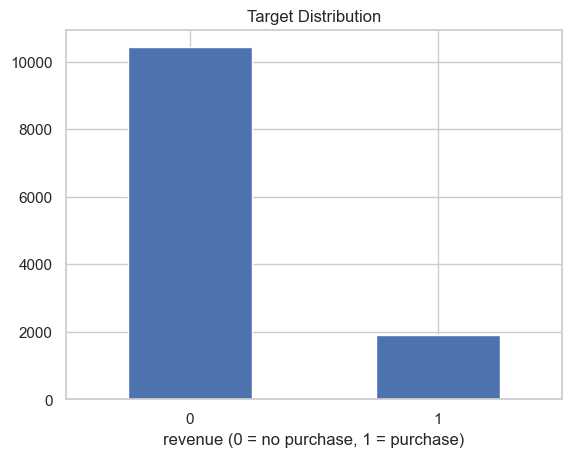

In [11]:
# Target distribution
print(df['revenue'].value_counts(normalize=True))
print()
print("Conversion Rate:")
global_conversion_rate = round(df['revenue'].mean(), 2)
print(global_conversion_rate)

# Target distribution plot
df['revenue'].value_counts().plot(kind='bar', title='Target Distribution')
plt.xticks(rotation=0)  # Rotate x-axis labels by 45 degrees
plt.xlabel('revenue (0 = no purchase, 1 = purchase)')
plt.show()


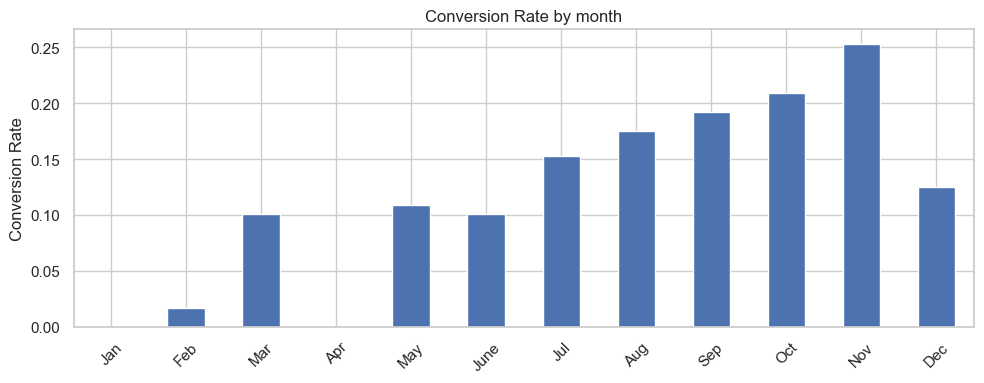

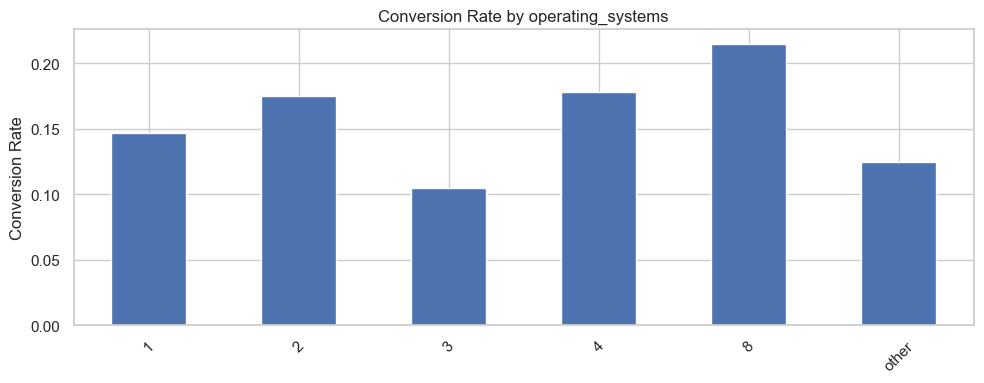

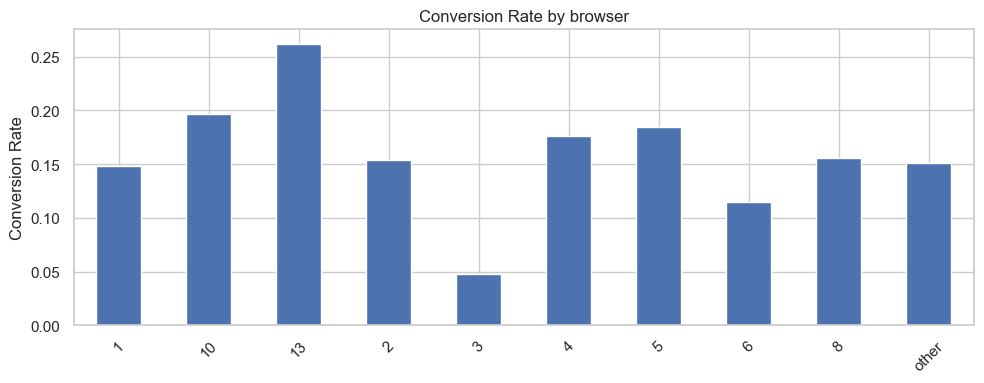

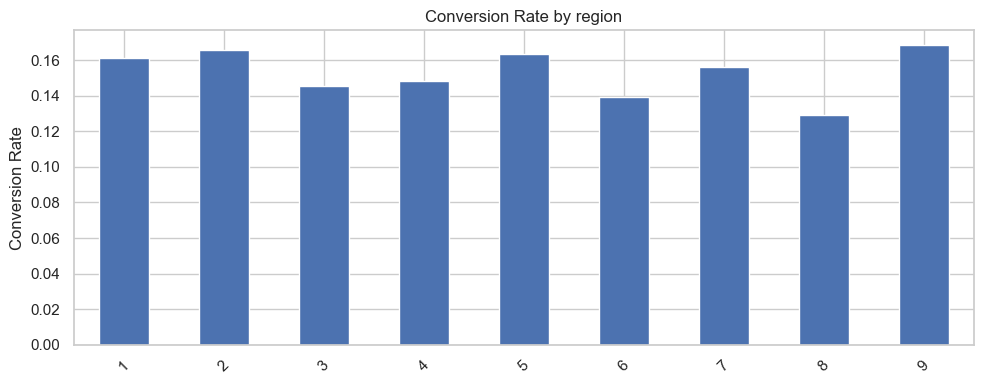

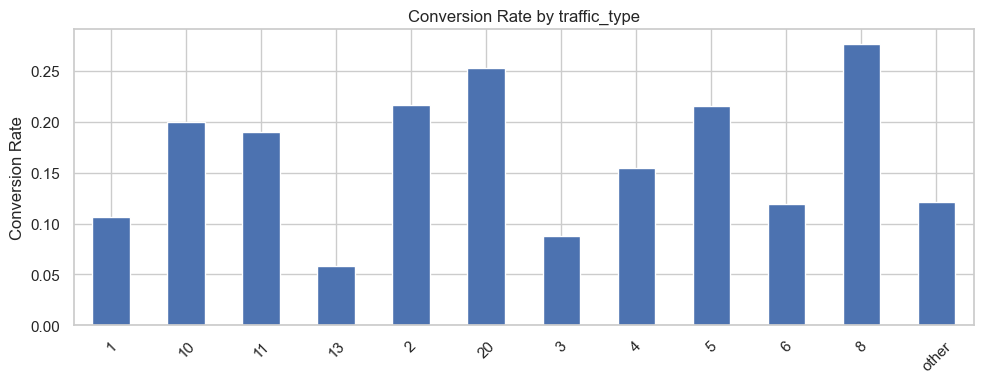

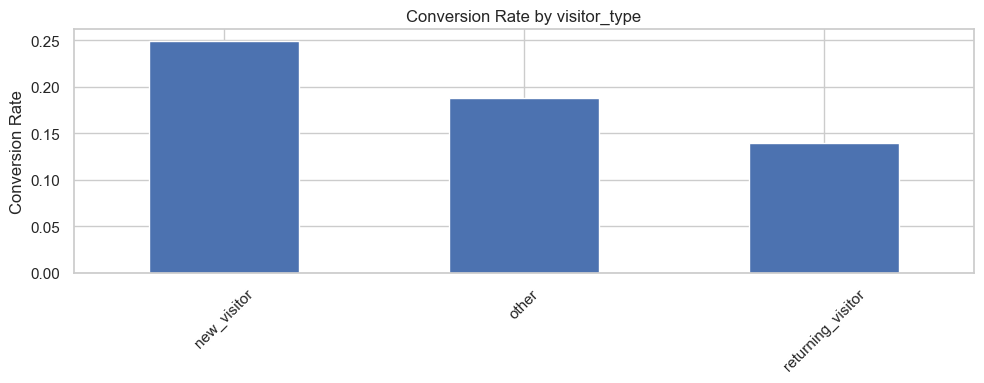

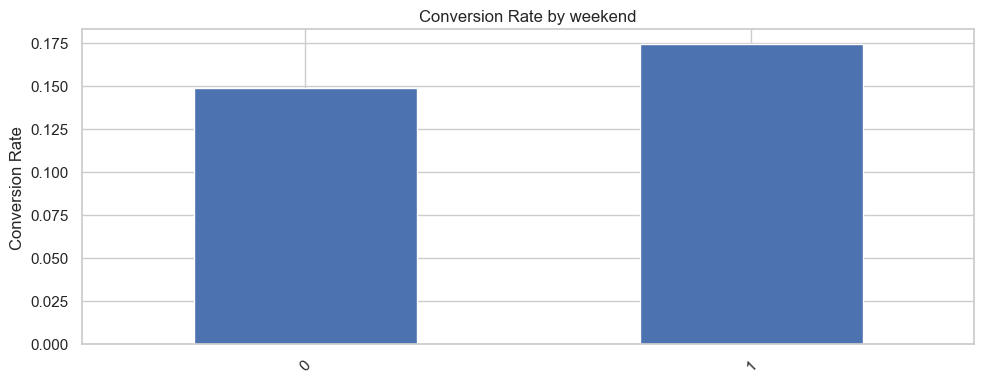

In [12]:
# Conversion rate by categorical variables

# Month ordering (chronological)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Convert 'month' to ordered categorical
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

# Loop through each categorical variable and plot conversion rate
for col in cat_cols:
    plt.figure(figsize=(10, 4))

    # Compute conversion rate
    conversion = df.groupby(col, observed=False)['revenue'].mean()

    # Try converting index to numeric, if possible
    try:
        conversion.index = conversion.index.astype(int)
        conversion = conversion.sort_index()
    except:
        pass  # leave non-numeric categories as they are

    # Chronological sorting for month
    if col == 'month':
        conversion = conversion.loc[month_order]

    # Plot
    conversion.plot(kind='bar')
    plt.title(f"Conversion Rate by {col}")
    plt.ylabel("Conversion Rate")
    plt.xlabel("")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [13]:
# Feature importance for categorical variables
feature_importance_tables = {}

for col in cat_cols:
    stats = (
        df.groupby(col, observed=True)['revenue']
          .agg(['mean', 'count'])
          .rename(columns={'mean': 'conversion_rate'})
    )
    
    stats['difference'] = stats['conversion_rate'] - global_conversion_rate # positive 'difference' means higher conversion than average
    stats['risk_ratio'] = stats['conversion_rate'] / global_conversion_rate # >1 means higher conversion than average

    # Store for later inspection
    feature_importance_tables[col] = stats.sort_values('risk_ratio', ascending=False)

    print(f"\nFeature Importance for {col}")
    display(stats.sort_values('risk_ratio', ascending=False))



Feature Importance for month


,conversion_rate,count,difference,risk_ratio
month,,,,
Nov,0.253502,2998,0.103502,1.690016
Oct,0.209472,549,0.059472,1.396478
Sep,0.191964,448,0.041964,1.279762
Aug,0.175520,433,0.025520,1.170131
Jul,0.152778,432,0.002778,1.018519
Dec,0.125072,1727,-0.024928,0.833816
May,0.108502,3364,-0.041498,0.723345
June,0.100694,288,-0.049306,0.671296
Mar,0.100682,1907,-0.049318,0.671211



Feature Importance for operating_systems


,conversion_rate,count,difference,risk_ratio
operating_systems,,,,
8,0.215190,79,0.065190,1.434599
4,0.177824,478,0.027824,1.185495
2,0.174973,6601,0.024973,1.166490
1,0.146615,2585,-0.003385,0.977434
other,0.125000,32,-0.025000,0.833333
3,0.104892,2555,-0.045108,0.699282



Feature Importance for browser


,conversion_rate,count,difference,risk_ratio
browser,,,,
13,0.262295,61,0.112295,1.748634
10,0.196319,163,0.046319,1.308793
5,0.184154,467,0.034154,1.227695
4,0.176630,736,0.026630,1.177536
8,0.155556,135,0.005556,1.037037
2,0.153624,7961,0.003624,1.024159
other,0.151515,66,0.001515,1.010101
1,0.148253,2462,-0.001747,0.988356
6,0.114943,174,-0.035057,0.766284



Feature Importance for region


,conversion_rate,count,difference,risk_ratio
region,,,,
9,0.168297,511,0.018297,1.121983
2,0.165493,1136,0.015493,1.103286
5,0.163522,318,0.013522,1.090147
1,0.161297,4780,0.011297,1.075314
7,0.156373,761,0.006373,1.042488
4,0.148054,1182,-0.001946,0.987028
3,0.145235,2403,-0.004765,0.968234
6,0.139130,805,-0.010870,0.927536
8,0.129032,434,-0.020968,0.860215



Feature Importance for traffic_type


,conversion_rate,count,difference,risk_ratio
traffic_type,,,,
8,0.276968,343,0.126968,1.846453
20,0.252525,198,0.102525,1.683502
2,0.216458,3913,0.066458,1.443053
5,0.215385,260,0.065385,1.435897
10,0.200000,450,0.050000,1.333333
11,0.190283,247,0.040283,1.268556
4,0.154350,1069,0.004350,1.028999
other,0.121212,165,-0.028788,0.808081
6,0.119369,444,-0.030631,0.795796



Feature Importance for visitor_type


,conversion_rate,count,difference,risk_ratio
visitor_type,,,,
new_visitor,0.249115,1694,0.099115,1.660763
other,0.188235,85,0.038235,1.254902
returning_visitor,0.139323,10551,-0.010677,0.928822



Feature Importance for weekend


,conversion_rate,count,difference,risk_ratio
weekend,,,,
1,0.173989,2868,0.023989,1.159926
0,0.148911,9462,-0.001089,0.992743


In [14]:
# Mutual Information for categorical variables
def mi_score(series):
    return mutual_info_score(series, df['revenue'])

df[cat_cols].apply(mi_score).sort_values(ascending=False) # Higher value means more important


month                0.015425
traffic_type         0.014831
visitor_type         0.004911
operating_systems    0.003207
browser              0.001113
weekend              0.000420
region               0.000381
dtype: float64

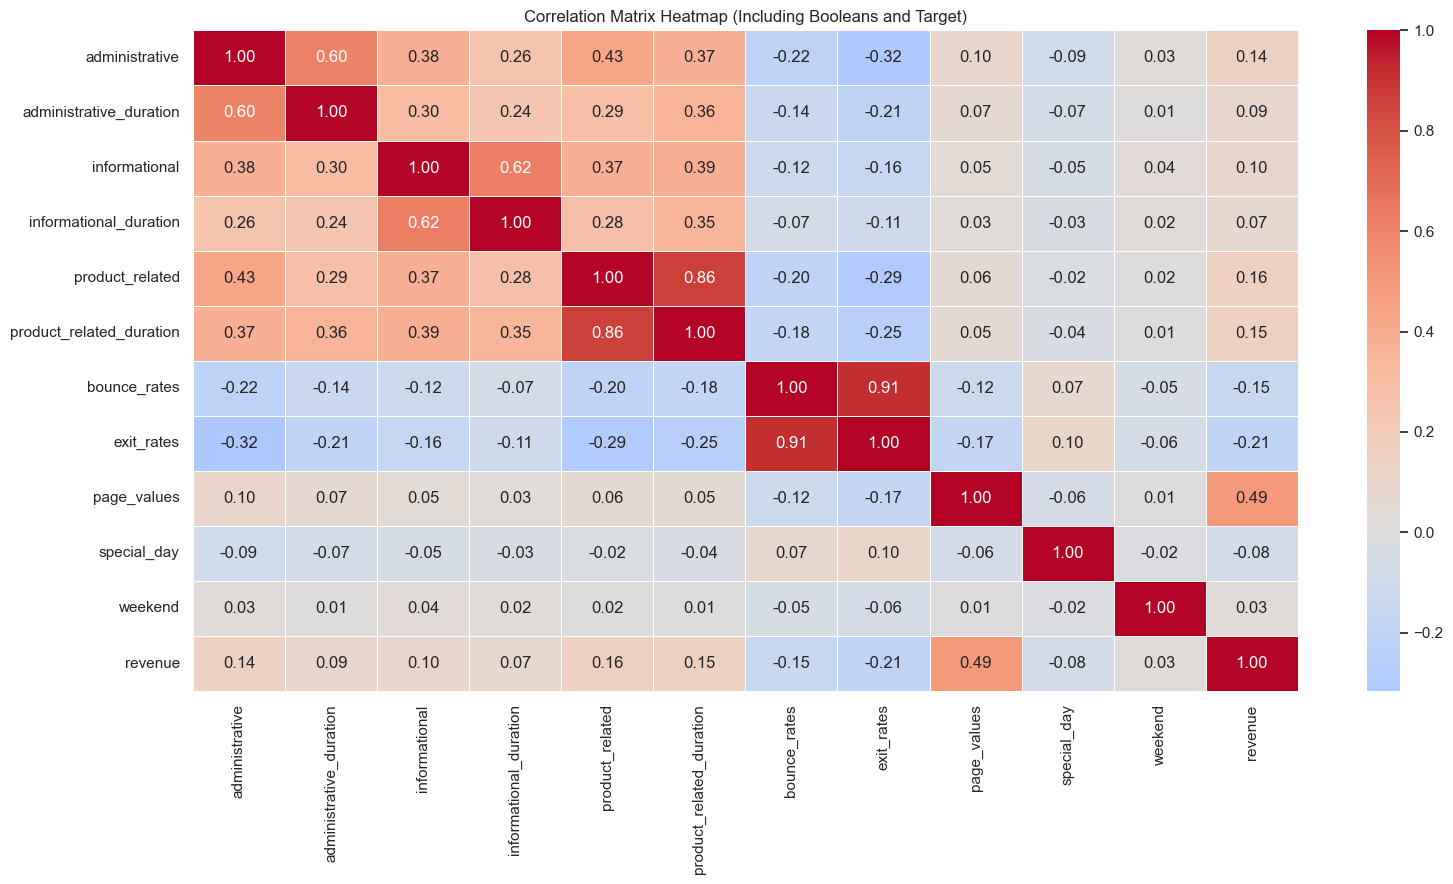

In [15]:
# Feature Importance for numerical variables

# Correlation Matrix (including booleans)
numeric_for_corr = df[num_cols + bool_cols]
corr_matrix = numeric_for_corr.corr()

# Heatmap of Correlation Matrix
plt.figure(figsize=(16, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix Heatmap (Including Booleans and Target)")
plt.tight_layout()
plt.show()

In [16]:
# Sorted correlation with target
print("Correlation with target variable 'revenue':\n")
print(corr_matrix['revenue'].sort_values(ascending=False)) # Higher absolute values means more important

Correlation with target variable 'revenue':

revenue                     1.000000
page_values                 0.492569
product_related             0.158538
product_related_duration    0.152373
administrative              0.138917
informational               0.095200
administrative_duration     0.093587
informational_duration      0.070345
weekend                     0.029295
special_day                -0.082305
bounce_rates               -0.150673
exit_rates                 -0.207071
Name: revenue, dtype: float64


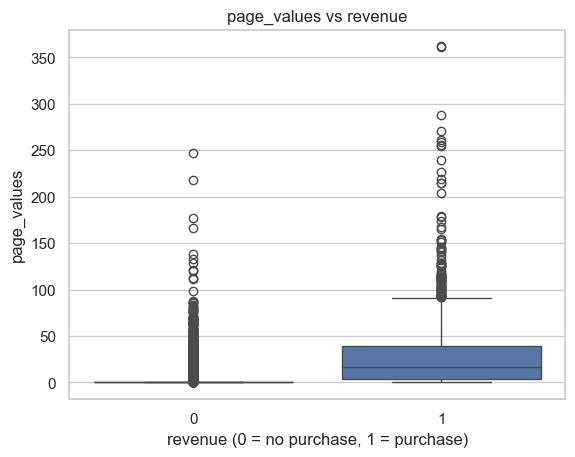

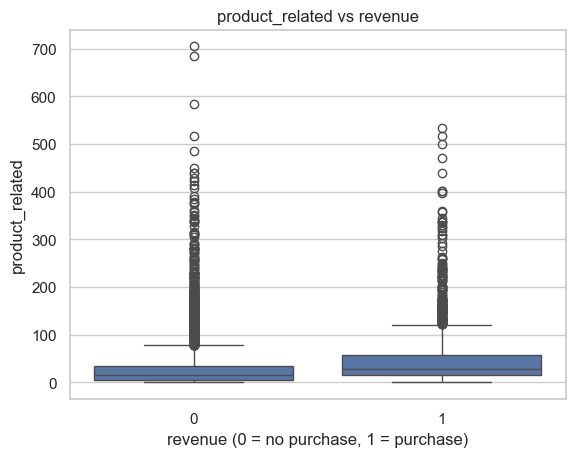

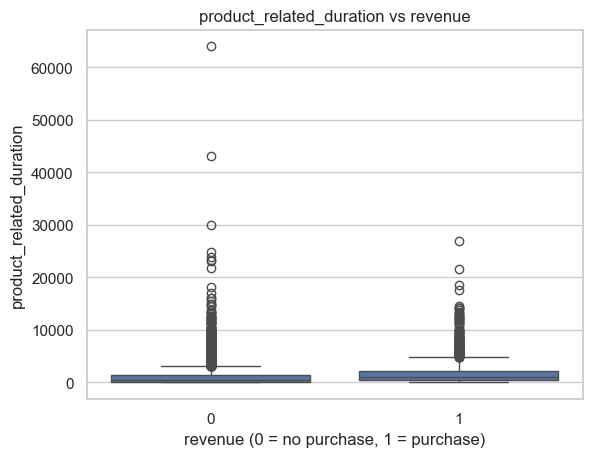

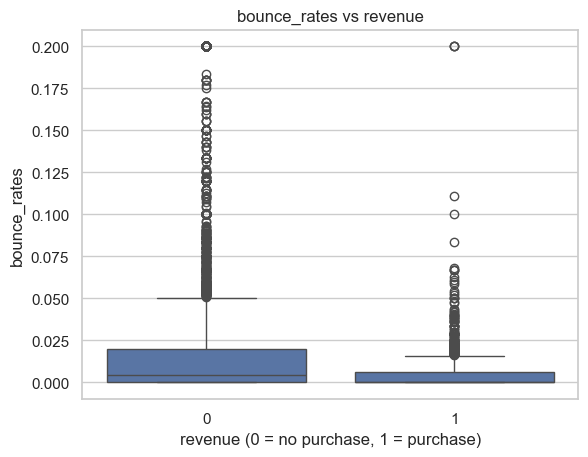

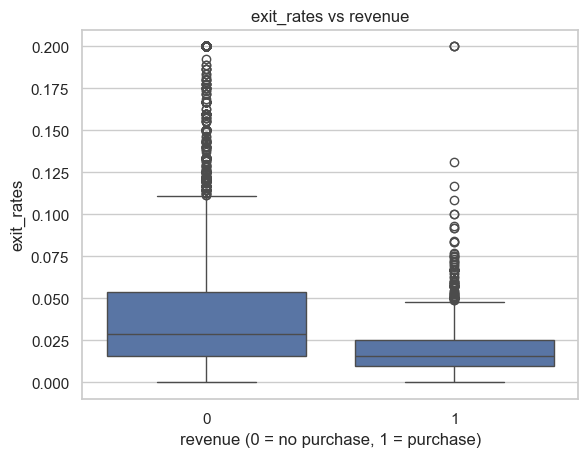

In [17]:
# Boxplots of key numerical features vs. revenue

# Focus on the numerical features that show the strongest relationship with revenue
important_num_cols = [
    'page_values',
    'product_related',
    'product_related_duration',
    'bounce_rates',
    'exit_rates'
]

# For each selected feature, plot a boxplot, split by revenue = 0 (no purchase) and revenue = 1 (purchase).
# This lets us visually compare the distributions between non-converting and converting sessions.
for col in important_num_cols:
    sns.boxplot(x='revenue', y=col, data=df)
    plt.title(f'{col} vs revenue')
    plt.xlabel('revenue (0 = no purchase, 1 = purchase)')
    plt.ylabel(col)
    plt.show()

## Key EDA Insights

- Conversions represent ~15% of all sessions (vs ~85% non-purchases), confirming a strong class imbalance.

- page_values, product_related, and product_related_duration show the strongest positive relationships with conversions, with page_values showing the highest correlation, indicating higher product engagement strongly predicts purchase. On the other hand, bounce_rates and exit_rates are substantially higher among non-purchasing sessions, confirming that quick exits and shallow engagement reduce buying likelihood.

- New visitors convert at ~25%, outperforming returning visitors (~14%) and “other” visitors (~19%), showing that first-time sessions carry surprisingly high purchase intent.

- Mutual information shows month and traffic_type as the most informative categorical features.

- Conversion rates follow a clear seasonal trend, peaking in November (~25%) and bottoming in February (~2%), likely driven by holiday shopping effects and monthly traffic quality.

# Split dataset

In [18]:
# Target variable
y = df['revenue'].values

# Drop target and define features
df = df.drop(columns=['revenue'])

RANDOM_STATE = 42 # reproducibility

# First split: full_train (80%) vs test (20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

y_full_train = y[df_full_train.index]
y_test = y[df_test.index]

# Second split: train (60%) vs train (20%) → from full_train (80%)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = y[df_train.index]
y_val = y[df_val.index]

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape


((7398, 17), (2466, 17), (2466, 17))

In [ ]:
sample = df_full_train.iloc[0].to_dict()
pprint.pprint(sample)


{'administrative': 0,
 'administrative_duration': 0.0,
 'bounce_rates': 0.0,
 'browser': '10',
 'exit_rates': 0.05,
 'informational': 0,
 'informational_duration': 0.0,
 'month': 'May',
 'operating_systems': '2',
 'page_values': 0.0,
 'product_related': 4,
 'product_related_duration': 104.0,
 'region': '2',
 'special_day': 0.0,
 'traffic_type': '2',
 'visitor_type': 'returning_visitor',
 'weekend': 0}


# Vectorization

In [19]:
# Vectorization
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)


# ML Models

## Logistic Regression

In [ ]:
# Logistic Regression Model (Baseline)
model = LogisticRegression(
    solver="liblinear",
    C=1.0,
    max_iter=1000,
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train)

y_val_pred = model.predict_proba(X_val)[:, 1]


In [ ]:
# Create dataframe for predictions vs actuals
revenue_prediction = (y_val_pred > 0.5)

df_val_pred = pd.DataFrame({
    'probability': y_val_pred,
    'prediction': revenue_prediction.astype(int),
    'actual': y_val,
})
print(df_val_pred.head(20))
print("\n")

    probability  prediction  actual
0      0.098842           0       0
1      0.090899           0       0
2      0.224231           0       0
3      0.046229           0       0
4      0.238421           0       0
5      0.891909           1       1
6      0.037572           0       0
7      0.027921           0       0
8      0.180469           0       0
9      0.125472           0       0
10     0.087558           0       0
11     0.203007           0       1
12     0.920176           1       0
13     0.047097           0       0
14     0.169573           0       1
15     0.073324           0       0
16     0.039620           0       0
17     0.020658           0       0
18     0.044186           0       0
19     0.033195           0       0




In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': dv.feature_names_,
    'coef': model.coef_[0]
}).sort_values(by='coef', ascending=False)

print("\nTop 10 Positive Features:")
print(feature_importance.head(10))
print("\nTop 10 Negative Features:")
print(feature_importance.tail(10))


Top 10 Positive Features:
            feature      coef
23        month=Nov  0.583392
55   traffic_type=8  0.424920
25        month=Sep  0.270583
50  traffic_type=20  0.203234
4        browser=10  0.202367
60          weekend  0.200652
46  traffic_type=10  0.192903
9         browser=5  0.188816
47  traffic_type=11  0.113089
16        month=Aug  0.103220

Top 10 Negative Features:
                           feature      coef
58              visitor_type=other -0.484407
51                  traffic_type=3 -0.492442
10                       browser=6 -0.534787
39                        region=5 -0.549587
17                       month=Dec -0.568086
59  visitor_type=returning_visitor -0.637989
18                       month=Feb -0.731940
2                     bounce_rates -0.883888
48                 traffic_type=13 -0.891382
13                      exit_rates -1.099191


In [ ]:
# Performance metrics
print("Validation Performance:")
print("ROC AUC:", roc_auc_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred > 0.5))
print("Recall:", recall_score(y_val, y_val_pred > 0.5))
print("F1:", f1_score(y_val, y_val_pred > 0.5))
print()

# Confusion Matrix
cm_baseline = confusion_matrix(y_val, y_val_pred > 0.5)
print("Confusion Matrix")
print(cm_baseline)
print()
cm_baseline_normalized = cm_baseline / cm_baseline.sum()
print(np.round(cm_baseline_normalized, 2))


Validation Performance:
ROC AUC: 0.9007373647547058
Precision: 0.7293577981651376
Recall: 0.4076923076923077
F1: 0.5230263157894737

Confusion Matrix
[[2017   59]
 [ 231  159]]

[[0.82 0.02]
 [0.09 0.06]]


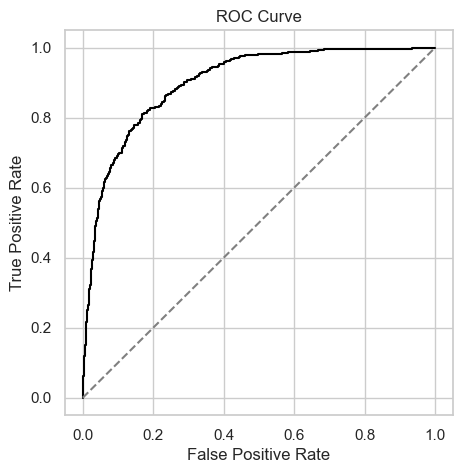

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], linestyle='dashed', color='grey')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [ ]:
# Cross-Validation
kfold = KFold(
    n_splits=5, 
    shuffle=True, 
    random_state=RANDOM_STATE      
)

model_cv = LogisticRegression(
    solver="liblinear",
    C=1.0,
    max_iter=1000,
    random_state=RANDOM_STATE      
)

# Compute ROC AUC scores across folds
scores = cross_val_score(
    model_cv, 
    X_train,          
    y_train,          
    cv=kfold, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"AUC per fold: {np.round(scores, 3).tolist()}")
print(f"Mean AUC: {scores.mean():.3f}")
print(f"Std of AUC: {scores.std():.3f}")


AUC per fold: [0.886, 0.868, 0.885, 0.912, 0.89]
Mean AUC: 0.888
Std of AUC: 0.014


In [ ]:
# Hyperparameter Tuning (C values)
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
results = []

print("Tuning regularization strength (C):\n")

for C in C_values:
    model_tune = LogisticRegression(
        solver="liblinear",
        C=C,
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    
    scores = cross_val_score(
        model_tune, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring='roc_auc',
        n_jobs=-1
    )
    
    results.append({
        'C': C,
        'mean_auc': scores.mean(),
        'std_auc': scores.std()
    })
    
    print(f"C={C:7.3f}  |  Mean AUC={scores.mean():.3f}  |  Std={scores.std():.3f}")

# Find best C
results_df = pd.DataFrame(results)
best_C = results_df.loc[results_df['mean_auc'].idxmax(), 'C']

print("\nBest C selected based on highest mean AUC:", best_C)


Tuning regularization strength (C):

C=  0.001  |  Mean AUC=0.813  |  Std=0.018
C=  0.010  |  Mean AUC=0.897  |  Std=0.015
C=  0.100  |  Mean AUC=0.893  |  Std=0.014
C=  1.000  |  Mean AUC=0.888  |  Std=0.014
C= 10.000  |  Mean AUC=0.888  |  Std=0.014
C=100.000  |  Mean AUC=0.886  |  Std=0.014

Best C selected based on highest mean AUC: 0.01


In [ ]:
# Final vectorizer fit on the full training data (80%)
full_train_dicts = df_full_train.to_dict(orient='records')

dv_final_lr = DictVectorizer(sparse=True)
X_full_train = dv_final_lr.fit_transform(full_train_dicts)

# Final model with best C found
lr_final_model = LogisticRegression(
    solver="liblinear",
    C=best_C,
    max_iter=1000,
    random_state=RANDOM_STATE
)

lr_final_model.fit(X_full_train, y_full_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(0.01)
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# Prepare test set
test_dicts = df_test.to_dict(orient='records')
X_test_final = dv_final_lr.transform(test_dicts)


In [ ]:
# Predict probabilities and labels
y_test_pred = lr_final_model.predict_proba(X_test_final)[:, 1]
y_test_pred_label = (y_test_pred > 0.5).astype(int)

# Metrics
print("Logistic Regression Performance")
print("ROC AUC:", roc_auc_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred_label))
print("Recall:", recall_score(y_test, y_test_pred_label))
print("F1:", f1_score(y_test, y_test_pred_label))

# Confusion matrix
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_test_pred_label)
print(cm_lr)
print()

# Confusion Matrix Normalized
cm_lr_normalized = cm_lr / cm_lr.sum()
print(np.round(cm_lr_normalized, 2))


Final Test Performance:
ROC AUC: 0.9101600964485126
Precision: 0.7071823204419889
Recall: 0.3646723646723647
F1: 0.48120300751879697

Confusion Matrix:
[[2062   53]
 [ 223  128]]

[[0.84 0.02]
 [0.09 0.05]]


In [ ]:
# Save the final model and vectorizer
model_artifacts = {
    'dv': dv_final_lr,
    'model': lr_final_model
}

with open("./models/logistic_regression.pkl", "wb") as f:
    pickle.dump(model_artifacts, f)


## Random Forest

In [ ]:
# Random Forest Model Baseline
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict_proba(X_val)[:, 1]

print("Random Forest - Validation Performance")
print("ROC AUC:", roc_auc_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf > 0.5))
print("Recall:", recall_score(y_val, y_val_pred_rf > 0.5))
print("F1:", f1_score(y_val, y_val_pred_rf > 0.5))


Random Forest - Validation Performance
ROC AUC: 0.9336927523343709
Precision: 0.75177304964539
Recall: 0.5435897435897435
F1: 0.6309523809523809


In [ ]:
# Cross-Validation for Random Forest
rf_cv = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

scores_rf = cross_val_score(
    rf_cv,
    X_train,
    y_train,
    cv=kfold,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"AUC per fold: {np.round(scores_rf, 3).tolist()}")
print(f"Mean AUC: {scores_rf.mean():.3f}")
print(f"Std AUC: {scores_rf.std():.3f}")


AUC per fold: [0.921, 0.902, 0.917, 0.926, 0.911]
Mean AUC: 0.915
Std AUC: 0.008


In [ ]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10]
}

results_rf = []

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        for s in param_grid['min_samples_split']:

            rf_tune = RandomForestClassifier(
                n_estimators=n,
                max_depth=d,
                min_samples_split=s,
                random_state=RANDOM_STATE,
                n_jobs=-1
            )

            scores = cross_val_score(
                rf_tune,
                X_train,
                y_train,
                cv=kfold,
                scoring='roc_auc',
                n_jobs=-1
            )

            results_rf.append({
                'n_estimators': n,
                'max_depth': d,
                'min_samples_split': s,
                'mean_auc': scores.mean(),
                'std_auc': scores.std()
            })

            print(f"n={n}, depth={d}, split={s} → AUC={scores.mean():.3f}")

# best combo
rf_results_df = pd.DataFrame(results_rf)
best_rf = rf_results_df.loc[rf_results_df['mean_auc'].idxmax()]
print("\nBest RF parameters:")
print(best_rf)


n=200, depth=None, split=5 → AUC=0.918
n=200, depth=None, split=10 → AUC=0.920
n=200, depth=10, split=5 → AUC=0.920
n=200, depth=10, split=10 → AUC=0.921
n=200, depth=20, split=5 → AUC=0.920
n=200, depth=20, split=10 → AUC=0.920
n=300, depth=None, split=5 → AUC=0.919
n=300, depth=None, split=10 → AUC=0.920
n=300, depth=10, split=5 → AUC=0.920
n=300, depth=10, split=10 → AUC=0.921
n=300, depth=20, split=5 → AUC=0.920
n=300, depth=20, split=10 → AUC=0.920

Best RF parameters:
n_estimators         200.000000
max_depth             10.000000
min_samples_split     10.000000
mean_auc               0.921028
std_auc                0.009480
Name: 3, dtype: float64


In [ ]:
# Final vectorizer fit
dv_rf = DictVectorizer(sparse=True)
X_full_train_rf = dv_rf.fit_transform(df_full_train.to_dict(orient='records'))

# Extract tuned params (convert numpy → python types)
best_n = int(best_rf["n_estimators"])
best_split = int(best_rf["min_samples_split"])

if pd.isna(best_rf["max_depth"]):
    best_depth = None
else:
    best_depth = int(best_rf["max_depth"])

# Final model
best_rf_model = RandomForestClassifier(
    n_estimators=best_n,
    max_depth=best_depth,
    min_samples_split=best_split,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

best_rf_model.fit(X_full_train_rf, y_full_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Transform test set
X_test_rf = dv_rf.transform(df_test.to_dict(orient='records'))

y_test_pred_rf = best_rf_model.predict_proba(X_test_rf)[:, 1]
y_test_pred_label_rf = (y_test_pred_rf > 0.5).astype(int)

print("Random Forest Performance")
print("ROC AUC:", roc_auc_score(y_test, y_test_pred_rf))
print("Precision:", precision_score(y_test, y_test_pred_label_rf))
print("Recall:", recall_score(y_test, y_test_pred_label_rf))
print("F1:", f1_score(y_test, y_test_pred_label_rf))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_test_pred_label_rf)
print(cm_rf)
print()

cm_rf_normalized = cm_rf / cm_rf.sum()
print(np.round(cm_rf_normalized, 2))


Random Forest - Final Test Performance
ROC AUC: 0.935011752978656
Precision: 0.8106796116504854
Recall: 0.4757834757834758
F1: 0.599640933572711

Confusion Matrix:
[[2076   39]
 [ 184  167]]

[[0.84 0.02]
 [0.07 0.07]]


In [ ]:
# Save the final Random Forest model and vectorizer
model_rf_artifacts = {
    'dv': dv_rf,
    'model': best_rf_model
}

with open("models/random_forest.pkl", "wb") as f:
    pickle.dump(model_rf_artifacts, f)


## XGBOOST Model

In [ ]:
# XGBOOST Model
xgb_base = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_base.fit(X_train, y_train)

y_val_pred_xgb = xgb_base.predict_proba(X_val)[:, 1]

print("XGBoost - Validation Performance")
print("ROC AUC:", round(roc_auc_score(y_val, y_val_pred_xgb), 3))
print("PR AUC :", round(average_precision_score(y_val, y_val_pred_xgb), 3))
print("Precision:", precision_score(y_val, y_val_pred_xgb > 0.5))
print("Recall   :", recall_score(y_val, y_val_pred_xgb > 0.5))
print("F1-score :", f1_score(y_val, y_val_pred_xgb > 0.5))


XGBoost (Baseline) - Validation Performance
ROC AUC: 0.937
PR AUC : 0.759
Precision: 0.7309941520467836
Recall   : 0.6410256410256411
F1-score : 0.6830601092896175


In [ ]:
# XGBoost Cross-Validation
xgb_cv = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

scores_xgb = cross_val_score(
    xgb_cv,
    X_train,
    y_train,
    cv=kfold,
    scoring="roc_auc",
    n_jobs=-1
)

print("XGBoost CV AUC per fold:", np.round(scores_xgb, 3).tolist())
print("Mean CV AUC:", scores_xgb.mean().round(3))
print("Std CV AUC :", scores_xgb.std().round(3))


XGBoost CV AUC per fold: [0.92, 0.907, 0.921, 0.93, 0.915]
Mean CV AUC: 0.919
Std CV AUC : 0.008


In [ ]:
# Hyperparameter tuning
param_grid = {
    'learning_rate': [0.3, 0.1, 0.05],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300, 400]
}

results_xgb = []

for lr in param_grid['learning_rate']:
    for depth in param_grid['max_depth']:
        for n_est in param_grid['n_estimators']:

            model_tune = XGBClassifier(
                learning_rate=lr,
                max_depth=depth,
                n_estimators=n_est,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="logloss",
                random_state=RANDOM_STATE,
                n_jobs=-1
            )

            scores = cross_val_score(
                model_tune,
                X_train,
                y_train,
                cv=kfold,
                scoring="roc_auc",
                n_jobs=-1
            )

            results_xgb.append({
                'learning_rate': lr,
                'max_depth': depth,
                'n_estimators': n_est,
                'mean_auc': scores.mean(),
                'std_auc': scores.std()
            })

            print(f"lr={lr}, depth={depth}, trees={n_est} → AUC={scores.mean():.3f}")

tune_df_xgb = pd.DataFrame(results_xgb)
best_xgb = tune_df_xgb.loc[tune_df_xgb['mean_auc'].idxmax()]

print("\nBest XGBoost Params:")
print(best_xgb)


lr=0.3, depth=4, trees=200 → AUC=0.906
lr=0.3, depth=4, trees=300 → AUC=0.903
lr=0.3, depth=4, trees=400 → AUC=0.901
lr=0.3, depth=6, trees=200 → AUC=0.907
lr=0.3, depth=6, trees=300 → AUC=0.905
lr=0.3, depth=6, trees=400 → AUC=0.903
lr=0.3, depth=8, trees=200 → AUC=0.906
lr=0.3, depth=8, trees=300 → AUC=0.904
lr=0.3, depth=8, trees=400 → AUC=0.903
lr=0.1, depth=4, trees=200 → AUC=0.922
lr=0.1, depth=4, trees=300 → AUC=0.920
lr=0.1, depth=4, trees=400 → AUC=0.917
lr=0.1, depth=6, trees=200 → AUC=0.919
lr=0.1, depth=6, trees=300 → AUC=0.916
lr=0.1, depth=6, trees=400 → AUC=0.913
lr=0.1, depth=8, trees=200 → AUC=0.917
lr=0.1, depth=8, trees=300 → AUC=0.915
lr=0.1, depth=8, trees=400 → AUC=0.912
lr=0.05, depth=4, trees=200 → AUC=0.927
lr=0.05, depth=4, trees=300 → AUC=0.925
lr=0.05, depth=4, trees=400 → AUC=0.923
lr=0.05, depth=6, trees=200 → AUC=0.925
lr=0.05, depth=6, trees=300 → AUC=0.923
lr=0.05, depth=6, trees=400 → AUC=0.921
lr=0.05, depth=8, trees=200 → AUC=0.922
lr=0.05, depth=8, 

In [ ]:
# Refit DictVectorizer on full training set
dv_xgb = DictVectorizer(sparse=True)
X_full_train_xgb = dv_xgb.fit_transform(df_full_train.to_dict(orient="records"))

best_xgb_model = XGBClassifier(
    learning_rate=float(best_xgb["learning_rate"]),
    max_depth=int(best_xgb["max_depth"]),
    n_estimators=int(best_xgb["n_estimators"]),
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

best_xgb_model.fit(X_full_train_xgb, y_full_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
X_test_xgb = dv_xgb.transform(df_test.to_dict(orient="records"))
y_test_pred_xgb = best_xgb_model.predict_proba(X_test_xgb)[:, 1]
y_test_pred_label_xgb = (y_test_pred_xgb > 0.5).astype(int)

print("XGBoost Performance")
print("ROC AUC:", round(roc_auc_score(y_test, y_test_pred_xgb), 4))
print("PR AUC:", round(average_precision_score(y_test, y_test_pred_xgb), 4))
print("Precision:", precision_score(y_test, y_test_pred_label_xgb))
print("Recall:", recall_score(y_test, y_test_pred_label_xgb))
print("F1-score:", f1_score(y_test, y_test_pred_label_xgb))

print("\nConfusion Matrix")
cm_xgb = confusion_matrix(y_test, y_test_pred_label_xgb)
print(cm_xgb)
print()
cm_xgb_normalized = cm_xgb / cm_xgb.sum()
print(np.round(cm_xgb_normalized, 2))


XGBoost - Final Test Performance
ROC AUC: 0.9382
PR AUC: 0.7469
Precision: 0.718213058419244
Recall: 0.5954415954415955
F1-score: 0.6510903426791277

Confusion Matrix
[[2033   82]
 [ 142  209]]

[[0.82 0.03]
 [0.06 0.08]]


In [ ]:
xgb_artifacts = {
    "dv": dv_xgb,
    "model": best_xgb_model
}

with open("models/xgboost.pkl", "wb") as f:
    pickle.dump(xgb_artifacts, f)
